In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
import imageio.v2 as iio
from IPython.display import display, Image

I will be following this training algorithm:

<p align="center">
    <img src="res/algo.png" width="400" />
</p>

As the parameters of the neural network are shared across time (noise level), I am employing sinusoidal position embeddings to encode $t$, inspired by [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)

Some constants

In [2]:
BS = 128    # batch size
TIME_EMBEDDING_DIM = 100
TIMESTAMPS = 300
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Declaring transformation steps for the detaset
trans = Compose([
    ToTensor(),
    Lambda(lambda t: (t*2) - 1)
])

mnist = datasets.MNIST(root="minist_data/", download=True, transform=trans)

train_dataloader = DataLoader(mnist, batch_size=BS, shuffle=True)

In [4]:
def visualize_dataset(dataloader):
  images = next(iter(dataloader))
  plt.figure(figsize=(15,15))
  for i in range(32):
    plt.subplot(8,8,i+1)
    img = np.transpose(images[0][i].numpy(), (1, 2, 0))  # Transpose the image dimensions
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis("off")

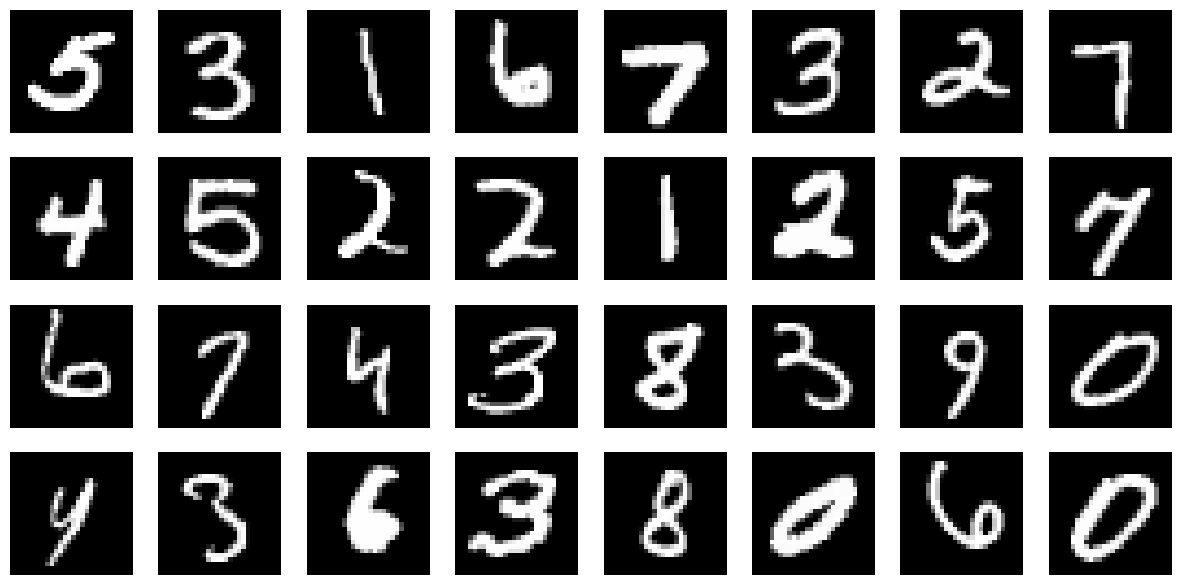

In [5]:
visualize_dataset(train_dataloader)

In [6]:
# Defining the building blocks of the model

class ConvBlock(nn.Module):
  """Convolution Block."""
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, time_emb_dim, last=False):
    super(ConvBlock, self).__init__()
    self.last = last
    self.time_mlp = nn.Linear(time_emb_dim, in_channels)
    self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    if not self.last:
      self.batch_norm_layer = nn.BatchNorm2d(out_channels)
      self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = x + t.view(*t.shape, 1, 1)
    x = self.conv_layer(x)
    if not self.last:
      x = self.batch_norm_layer(x)
      x = self.act(x)
    return x


class UpSampleBlock(nn.Module):
  """Up Sampling Block."""
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, time_emb_dim, last=False):
    super(UpSampleBlock, self).__init__()
    self.last = last
    self.time_mlp = nn.Linear(time_emb_dim, in_channels)
    self.conv_trans_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
    if not self.last:
      self.batch_norm_layer = nn.BatchNorm2d(out_channels)
      self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = x + t.view(*t.shape, 1, 1)
    x = self.conv_trans_layer(x)
    if not self.last:
      x = self.batch_norm_layer(x)
      x = self.act(x)
    return x


class LinearBlock(nn.Module):
  """Linear Block."""
  def __init__(self, in_dim, out_dim, time_emb_dim):
    super(LinearBlock, self).__init__()
    self.time_mlp = nn.Linear(time_emb_dim, in_dim)
    self.linear_layer = nn.Linear(in_dim, out_dim)
    self.batch_norm_layer = nn.BatchNorm1d(out_dim)
    self.act = nn.LeakyReLU()

  def forward(self, x, t):
    t = self.time_mlp(t)
    x = x + t
    x = self.linear_layer(x)
    x = self.batch_norm_layer(x)
    x = self.act(x)
    return x


class SinusoidalPositionEmbeddings(nn.Module):
    """Encode timestep to dim dimensional vector"""
    def __init__(self, dim):
      super(SinusoidalPositionEmbeddings, self).__init__()
      self.dim = dim

    def forward(self, time):
      device = time.device
      half_dim = self.dim // 2
      embeddings = np.log(10000) / (half_dim - 1)
      embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
      embeddings = time[:, None] * embeddings[None, :]
      embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

      return embeddings


In [7]:
class Reshape(nn.Module):
    """A custom reshape layer."""
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)


class DiffusionModel(nn.Module):
    """Diffusion model"""
    def __init__(self, time_emb_dim):
        super(DiffusionModel, self).__init__()
        self.time_emb_dim = time_emb_dim

        self.time_embedding_model = nn.Sequential(
            SinusoidalPositionEmbeddings(200),
            nn.Linear(200, time_emb_dim),
            nn.LeakyReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.dsb_1 = ConvBlock(in_channels=1, out_channels=64, kernel_size=5, stride=2, padding=2, time_emb_dim=time_emb_dim)
        self.conv1 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.dsb_2 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, time_emb_dim=time_emb_dim)

        self.flatten = nn.Flatten(1, -1)

        self.linear_1 = LinearBlock(in_dim=256 * 7 * 7, out_dim=256, time_emb_dim=time_emb_dim)
        self.linear_2 = LinearBlock(in_dim=256, out_dim=128, time_emb_dim=time_emb_dim)
        self.linear_3 = LinearBlock(in_dim=128, out_dim=256 * 7 * 7, time_emb_dim=time_emb_dim)

        self.reshape = Reshape((-1, 256, 7, 7))

        self.usb_1 = UpSampleBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim)
        self.conv2 = ConvBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.usb_2 = UpSampleBlock(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, time_emb_dim=time_emb_dim)
        self.conv3 = ConvBlock(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, time_emb_dim=time_emb_dim)
        self.conv4 = ConvBlock(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0, time_emb_dim=time_emb_dim, last=True)

    def forward(self, x, t):
        t = self.time_embedding_model(t)
        x1 = self.dsb_1(x, t)
        x2 = self.conv1(x1, t)
        x3 = self.dsb_2(x2, t)

        x3_ = self.flatten(x3)
        x4 = self.linear_1(x3_, t)
        x5 = self.linear_2(x4, t)
        x = self.linear_3(x5, t)
        x = self.reshape(x)

        x = self.usb_1(x + x3, t)
        x = self.conv2(x, t)
        x = self.usb_2(x + x2, t)
        x = self.conv3(x, t)
        x = self.conv4(x, t)

        return x


In [8]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# Define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTAMPS)

# Define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [9]:
# Forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [10]:
def p_losses(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    loss = nn.functional.smooth_l1_loss(noise, predicted_noise)

    return loss

In [11]:
def train(net, epochs, lr):

    optimizer = torch.optim.Adam(net.parameters(), lr)

    # Training loop
    for i in range(1,epochs+1):
        running_loss = 0
        pbar = tqdm(train_dataloader)
        for b, data in enumerate(pbar):
            # Every data instance is an input + label pair. We don't need the label
            inputs, _ = data
            inputs = inputs.to(device)

            # Zero the gradients for every batch!
            optimizer.zero_grad()

            t = torch.randint(0, TIMESTAMPS, (inputs.shape[0],), device=device).long()

            # Compute the loss and its gradients
            loss = p_losses(net, inputs, t)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Update Progress
            running_loss += loss.item()
            pbar.set_description(f"Epoch {i}/{epochs}: ")
            pbar.set_postfix({"batch_loss": loss.item(), "avg_loss": running_loss/(b+1)})

In [12]:
net = DiffusionModel(time_emb_dim=TIME_EMBEDDING_DIM)
net.to(device)

DiffusionModel(
  (time_embedding_model): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (dsb_1): ConvBlock(
    (time_mlp): Linear(in_features=100, out_features=1, bias=True)
    (conv_layer): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (batch_norm_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (conv1): ConvBlock(
    (time_mlp): Linear(in_features=100, out_features=64, bias=True)
    (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_layer): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (dsb_2): ConvBlock(
    (time_mlp): Linear(in_features=100, out_features=128, bias=True)

In [13]:
train(net, 50, 1e-3)

Epoch 50/50: : 100%|██████████| 469/469 [00:11<00:00, 41.36it/s, batch_loss=0.0218, avg_loss=0.0198]


In [14]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, TIMESTAMPS)), desc='sampling loop time step', total=TIMESTAMPS):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


sampling loop time step: 100%|██████████| 300/300 [00:01<00:00, 239.33it/s]


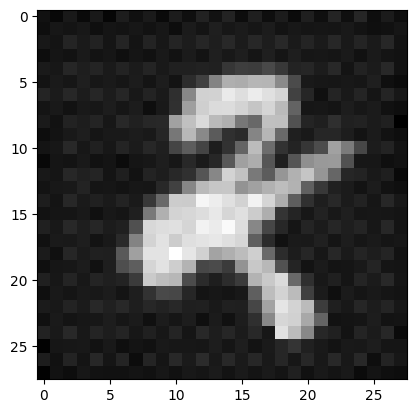

In [15]:
# sample 64 images
samples = sample(net, image_size=28, batch_size=64, channels=1)

# show a random one
random_index = 3
plt.imshow(samples[-1][random_index].reshape(28, 28), cmap="gray")

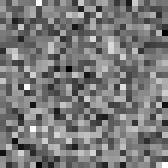

In [18]:
random_index = 53

# Collect image data in the proper format
ims = []
for i in range(TIMESTAMPS):
    img = samples[i][random_index].squeeze()  # Squeeze to remove single-dimensional entries from the shape
    ims.append(img)

# Scale images to desired size (e.g., double the size)
scaled_ims = [np.kron(img, np.ones((6, 6))) for img in ims]  # Example: Double the size using np.kron

# Normalize pixel values to range [0, 255]
scaled_ims = [(img - np.min(img)) / (np.max(img) - np.min(img)) * 255 for img in scaled_ims]
scaled_ims = [img.astype(np.uint8) for img in scaled_ims]

iio.mimsave('generated_images.gif', scaled_ims, duration=0.1)

with open('generated_images.gif', 'rb') as f:
    display(Image(data=f.read(), format='gif'))